<a href="https://colab.research.google.com/github/kvolle/SpeedGitDemo/blob/Demo/Tiny_Kyle's_Speed_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Comma AI Speed Challenge**

  This notebook will contain (hopefully) all of the functions you need to import the data into your model.

  ***Be sure to train with GPU acceleration enabled***

**Import Statements**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
x = np.load("./drive/My Drive/commai_dataset/data/data_001.npy")

**Custom Data Generator**

This works (I think) for giving two sequential images to a Keras Functional model as well as the velocity associated with the second image.

At this point, don't worry about how this works. If you need something changed or fixed, just ask. This is the boring part anyways.

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.direct = "./drive/My Drive/commai_dataset/"

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.list_IDs) #int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        # Find list of IDs
        list_IDs_temp = self.list_IDs[index]
        # Generate data
        #print(index)
        #print(list_IDs_temp)
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.load(self.direct+"data/data_" + list_IDs_temp +".npy")
        x1 = X[0:101,:,:,:]/255.
        x2 = X[1:102,:,:,:]/255.
        y = np.load(self.direct+"labels/label_" + list_IDs_temp +".npy")
        y = y[1:102]/10.

        return [x1, x2], y

**Define custom loss function**

This is not well tested, neither is it optimized. You might not even want to use this function.

Keras backend functions are a powerful tool for writing custom loss functions. To define a loss function it just has to accept *y_true* and *y_pred* as arguments and return a float.

To use your new loss function, change the argument in *model.compile()*.

In [ ]:
def mean_sq_err(y_true, y_pred):
  #y_pred = 15. + y_pred*15.
  return tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred)) + metric_var(y_true, y_pred)#1./(0.001+tf.keras.backend.var(y_pred))

In [ ]:
def mean_psuedo_huber(y_true, y_pred):
  scale = 2
  huber = scale*scale*(tf.keras.backend.sqrt(1+tf.keras.backend.square((y_true-y_pred)/scale)) - 1)
  return tf.keras.backend.mean(huber)

In [ ]:
def metric_var(y_true, y_pred):
  #return 1./(0.001+tf.keras.backend.var(y_pred))
  epsilon = 0.001
  return tf.keras.backend.maximum((epsilon + tf.keras.backend.var(y_true))/(epsilon+tf.keras.backend.var(y_pred)), 1)

In [ ]:
def mean_psuedo_huber_var(y_true, y_pred):
  scale_factor = 10.
  return scale_factor*mean_psuedo_huber(y_true, y_pred) + metric_var(y_true, y_pred)

**Define the test-train split and create the Data Generator**

In [ ]:
params = {'dim': (110,320),
          'batch_size': 101,
          'n_classes': 1,
          'n_channels': 3,
          'shuffle': False}

train_data = []
train_label = []
valid_data = []
valid_label = []

for i in range(70):
    train_data.append("%03d" %i)
    train_data.append("%03d" %(i+100))

for i in range(70, 100):
    valid_data.append("%03d" %i)
    valid_data.append("%03d" %(i+100))

partition={'train':train_data, 'validation':valid_data}
labels = {'train': train_label,'validation':valid_label}

training_generator = DataGenerator(partition['train'], labels['train'], **params)
validation_generator =DataGenerator(partition['validation'], labels['validation'], **params)

**Define the input layers**

In [ ]:
input_A = tf.keras.layers.Input(shape=(110, 320, 3), name="first_image")
input_B = tf.keras.layers.Input(shape=(110, 320, 3), name="second_image")

**Define the model**

This model is a particularly ridiculous placeholder. Make yours better

In [ ]:
#resnet = applications.resnet_v2.ResNet150V2(include_top=False, weights='imagenet', input_shape=(110, 320, 3), pooling=None)
#resnet_reshape = tf.keras.layers.Flatten()(resnet.output)
#fc1 = tf.keras.layers.Dense(256, activation='relu')(resnet_reshape)
#fc2 = tf.keras.layers.Dense(512, activation='relu')(fc1)
#out = tf.keras.layers.Dense(128, activation='relu')(fc2)
#side = tf.keras.models.Model(inputs = resnet.input, outputs = out)
#input_A = layers.Input(shape=(110, 320, 3), name="input_a")
#input_B = layers.Input(shape=(110), 320, 3), name="input_b")
#input_match = layers.Input(shape=[1])

#output_A = side(input_A)
#output_B = side(input_B)

In [ ]:
"""
#resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=(110, 320, 3), pooling=None)
side_input = tf.keras.layers.Input(shape=(110, 320, 3), name="side_input")
pre_split_conv_1 = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2(), name=)(side_input)
pre_split_conv_2 = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(pre_split_conv_1)
hybrid = tf.keras.layers.concatenate([pre_split_conv_1, pre_split_conv_2])
side_output = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(hybrid)
side = tf.keras.models.Model(inputs = side_input, outputs = side_output)
res_a = side(input_A)
res_b = side(input_B)
#abs_diff = tf.keras.backend.abs(res_b-res_a)
#conv_1 = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(abs_diff)
concat = tf.keras.layers.concatenate([res_a, res_b])
conv_1 = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(concat)
conv_1 = tf.keras.layers.MaxPool2D()(conv_1)
conv_2 = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(conv_1)
conv_2 = tf.keras.layers.MaxPool2D((3,3))(conv_2)
flat = tf.keras.layers.Flatten()(conv_2)
dense_1 = tf.keras.layers.Dense(128, activation='tanh')(flat)
dense_2 = tf.keras.layers.Dense(32, activation='tanh')(dense_1)
dense_3 = tf.keras.layers.Dense(1, activation='relu')(dense_2)
model = tf.keras.models.Model(inputs=[input_A, input_B], outputs=dense_3)
"""

'\n#resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights=\'imagenet\', input_shape=(110, 320, 3), pooling=None)\nside_input = tf.keras.layers.Input(shape=(110, 320, 3), name="side_input")\npre_split_conv_1 = tf.keras.layers.Conv2D(32, (3,3), padding=\'same\', kernel_regularizer=tf.keras.regularizers.l1_l2(), name=)(side_input)\npre_split_conv_2 = tf.keras.layers.Conv2D(32, (3,3), padding=\'same\', kernel_regularizer=tf.keras.regularizers.l1_l2())(pre_split_conv_1)\nhybrid = tf.keras.layers.concatenate([pre_split_conv_1, pre_split_conv_2])\nside_output = tf.keras.layers.Conv2D(64, (3,3), padding=\'same\', kernel_regularizer=tf.keras.regularizers.l1_l2())(hybrid)\nside = tf.keras.models.Model(inputs = side_input, outputs = side_output)\nres_a = side(input_A)\nres_b = side(input_B)\n#abs_diff = tf.keras.backend.abs(res_b-res_a)\n#conv_1 = tf.keras.layers.Conv2D(32, (3,3), padding=\'same\', kernel_regularizer=tf.keras.regularizers.l1_l2())(abs_diff)\nconcat = tf.k

In [ ]:
def create_side():
  side_input = tf.keras.layers.Input(shape=(110, 320, 3), name="side_input")
  pre_split_conv_1 = tf.keras.layers.Conv2D(16, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(side_input)
  pre_split_conv_1 = tf.keras.layers.MaxPool2D((2,2))(pre_split_conv_1)
  side_output = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(pre_split_conv_1)
  return tf.keras.models.Model(inputs = side_input, outputs = side_output)

In [ ]:
"""
side = create_side() 
res_a = side(input_A)
res_b = side(input_B)
#abs_diff = tf.keras.backend.abs(res_b-res_a)
#conv_1 = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(abs_diff)
concat = tf.keras.layers.concatenate([res_a, res_b])
conv_1 = tf.keras.layers.Conv2D(16, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(concat)
conv_1 = tf.keras.layers.MaxPool2D()(conv_1)
conv_2 = tf.keras.layers.Conv2D(16, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(conv_1)
conv_2 = tf.keras.layers.MaxPool2D((3,4))(conv_2)
flat = tf.keras.layers.Flatten()(conv_2)
dense_1 = tf.keras.layers.Dense(128, activation='tanh')(flat)
dense_1 = tf.keras.layers.Dropout(0.5)(dense_1)
dense_2 = tf.keras.layers.Dense(32, activation='tanh')(dense_1)
dense_2 = tf.keras.layers.Dropout(0.25)(dense_2)
dense_3 = tf.keras.layers.Dense(1, activation='relu')(dense_2)
model = tf.keras.models.Model(inputs=[input_A, input_B], outputs=dense_3)
"""

"\nside = create_side() \nres_a = side(input_A)\nres_b = side(input_B)\n#abs_diff = tf.keras.backend.abs(res_b-res_a)\n#conv_1 = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(abs_diff)\nconcat = tf.keras.layers.concatenate([res_a, res_b])\nconv_1 = tf.keras.layers.Conv2D(16, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(concat)\nconv_1 = tf.keras.layers.MaxPool2D()(conv_1)\nconv_2 = tf.keras.layers.Conv2D(16, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(conv_1)\nconv_2 = tf.keras.layers.MaxPool2D((3,4))(conv_2)\nflat = tf.keras.layers.Flatten()(conv_2)\ndense_1 = tf.keras.layers.Dense(128, activation='tanh')(flat)\ndense_1 = tf.keras.layers.Dropout(0.5)(dense_1)\ndense_2 = tf.keras.layers.Dense(32, activation='tanh')(dense_1)\ndense_2 = tf.keras.layers.Dropout(0.25)(dense_2)\ndense_3 = tf.keras.layers.Dense(1, activation='relu')(dense_2)\nmodel = tf.keras.models.Model(inputs=[in

In [ ]:
side = create_side() 
res_a = side(input_A)
res_b = side(input_B)
#abs_diff = tf.keras.backend.abs(res_b-res_a)
#conv_1 = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(abs_diff)
concat = tf.keras.layers.concatenate([res_a, res_b])
conv_1 = tf.keras.layers.Conv2D(16, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(concat)
conv_1 = tf.keras.layers.MaxPool2D((3,4))(conv_1)
conv_2 = tf.keras.layers.Conv2D(16, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2())(conv_1)
conv_2 = tf.keras.layers.MaxPool2D((3,4))(conv_2)
flat = tf.keras.layers.Flatten()(conv_2)
dense_1 = tf.keras.layers.Dense(128)(flat)
dense_2 = tf.keras.layers.Dense(64)(dense_1)
dense_3 = tf.keras.layers.Dense(1, activation='relu')(dense_2)
model = tf.keras.models.Model(inputs=[input_A, input_B], outputs=dense_3)

**How ridiculous? Run this next cell and find out.**

(Note how many parameters there are, at least it trains fast)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_image (InputLayer)        [(None, 110, 320, 3) 0                                            
__________________________________________________________________________________________________
second_image (InputLayer)       [(None, 110, 320, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 55, 160, 32)  5088        first_image[0][0]                
                                                                 second_image[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 55, 160, 64)  0           model[1][0]                

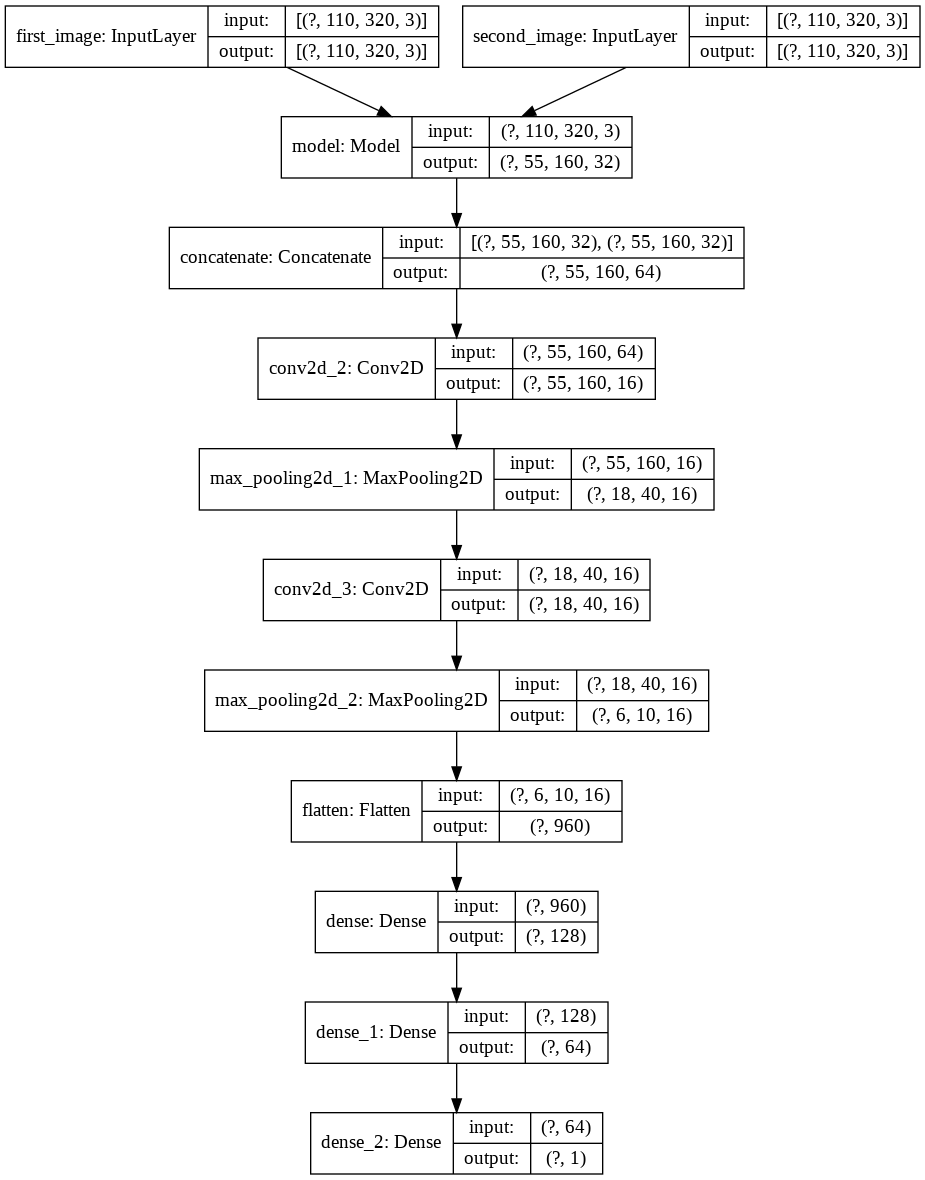

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

**Declare the optimizer and loss function, then compile your *less ridiculous*  model**

In [ ]:
_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=_optimizer, loss = mean_psuedo_huber,  metrics=[metric_var, mean_sq_err])

In [ ]:
#model.load_weights("./drive/My Drive/SpeedChallenge/CheckpointsGAN/regularizer_cosine_20.h5", by_name=True, skip_mismatch=True)

In [ ]:
#model.load_weights("./drive/My Drive/SpeedChallenge/Checkpoints/regularizer_cosine_11.h5")

**Train using the fit_generator**

In [ ]:
#model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=4, initial_epoch=0)

In [ ]:
%load_ext tensorboard

In [ ]:
logdir = "./drive/My Drive/SpeedChallenge/Logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq=1250)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./drive/My Drive/SpeedChallenge/Checkpoints/removed_activations_changed_pool{epoch}.h5", save_weights_only=True,  verbose=0)

In [ ]:
#model.load_weights("./drive/My Drive/SpeedChallenge/Checkpoints/regularizer_var_ratio__scale50.h5", by_name=True)

In [ ]:
model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=32, initial_epoch=0,callbacks=[tensorboard_callback, cp_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/32
140/140 [==============================] - 413s 3s/step - loss: 8.0245 - metric_var: 1.7897 - mean_sq_err: 2.3098 - val_loss: 6.2015 - val_metric_var: 1.4720 - val_mean_sq_err: 1.8782
Epoch 2/32
140/140 [==============================] - 435s 3s/step - loss: 4.7713 - metric_var: 1.5600 - mean_sq_err: 1.8496 - val_loss: 3.6877 - val_metric_var: 1.7647 - val_mean_sq_err: 2.2287
Epoch 3/32
140/140 [==============================] - 434s 3s/step - loss: 2.8669 - metric_var: 1.4742 - mean_sq_err: 1.7324 - val_loss: 2.3221 - val_metric_var: 1.1952 - val_mean_sq_err: 1.5665
Epoch 4/32
140/140 [==============================] - 438s 3s/step - loss: 1.8260 - metric_var: 1.3962 - mean_sq_err: 1.6024 - val_loss: 1.5276 - val_metric_var: 1.2900 - val_mean_sq_err: 1.6043
Epoch 5/32
140/140 [==============================] - 436s 3s/step - loss: 1.2318 - metric_var: 1.2332 - mean_sq_err: 1.4226 - val_loss: 1.0804 

In [ ]:
%tensorboard --logdir ./drive/My\ Drive/SpeedChallenge/Logs/20200630-032031/

In [ ]:
x = np.load("./drive/My Drive/commai_dataset/data/data_000.npy")
truth = np.load("./drive/My Drive/commai_dataset/labels/label_000.npy")
x1 = x[0:10,:,:,:]/255.
x2 = x[1:11,:,:,:]/255.
y = model.predict([x1, x2])

In [ ]:
print(y)
print(truth[1:11])